## Marketing Exploratory Data Analysis
### Notebook by Kymberly Ayodeji

### Step 0: Install Libraries and Packages

In [1]:
# Basic Numerical Libraries
import pandas as pd
import numpy as np

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Step 1: Load Data

In [2]:
data = pd.read_csv("data/CDNOW_master.txt", sep="\s+", names=["customer_id", "date", "quantity", "price"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kymno\AppData\Local\Temp\ipykernel_29784\1906795430.py:1: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv("data/CDNOW_master.txt", sep="\s+", names=["customer_id", "date", "quantity", "price"])


In [4]:
print('Number of transactions:\t', data.shape[0])
print('Number of customers:\t', data['customer_id'].nunique())
print('Date range:\t\t', data['date'].min(), 'to', data['date'].max())
print('Price range:\t\t$', data['price'].min(), 'to $', data['price'].max())


Number of transactions:	 69659
Number of customers:	 23570
Date range:		 19970101 to 19980630
Price range:		$ 0.0 to $ 1286.01


#### 1.0: Notes:
* 69,659 rows and 4 columns
* No null entries
* date column is of type int65 and will need to be converted to datetime

In [5]:
# Convert date column to string and then to datetime object
data = data \
    .assign(date = lambda x: x['date'].astype(str)) \
    .assign(date = lambda x: pd.to_datetime(x['date'])) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


### 2.0 Initial Exploratory Analysis
- 2.1 Numerical descriptions
- 2.2 Graphical distributions
- 2.3 Handling of any outliers
- 2.4 Correlation Analysis

In [6]:
# 2.1 
qp = ['quantity','price'] # identifying the numerical columns
data[qp].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,69659.0,2.410040,2.333924,1.0,1.00,2.00,3.0,99.00
price,69659.0,35.893648,36.281942,0.0,14.49,25.98,43.7,1286.01


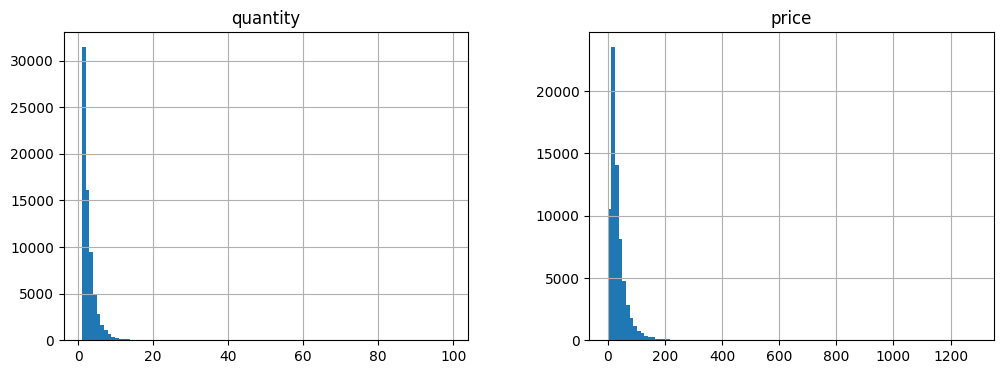

In [7]:
#2.2
data[qp].hist(bins=100, figsize=(12, 4), layout=(1, 2));

In [8]:
print(f"Skewness: Quantity {data['quantity'].skew():.2f}, Price {data['price'].skew():.2f}")

Skewness: Quantity 5.86, Price 5.66


Both numerical features are quite skewed with several outliers. Lets see if a log transform can adress the skewness.

<Axes: ylabel='Count'>

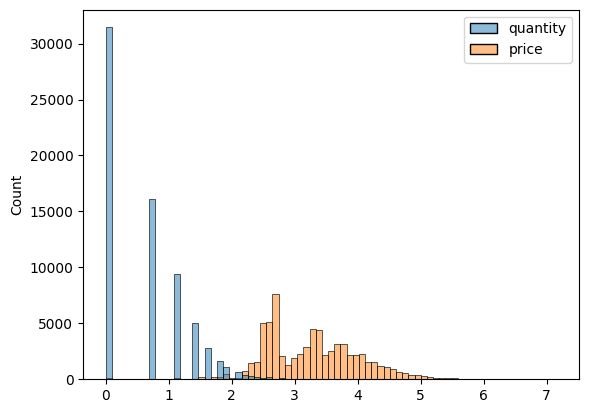

In [9]:
log_data = data[qp].map(lambda i: np.log(i) if i > 0 else 0)
sns.histplot(log_data )

In [10]:
# Outliers
des_data = data[qp].describe().T
# compute IQR and 1.5 * IQR
des_data['IQR'] = des_data['75%'] - des_data['25%']
des_data['1.5_IQR']= 1.5*des_data['IQR']
    
# establish outlier bounds
des_data['u_outlier_bound'] = des_data['75%'] + des_data['1.5_IQR']
des_data

,count,mean,std,min,25%,50%,75%,max,IQR,1.5_IQR,u_outlier_bound
quantity,69659.0,2.410040,2.333924,1.0,1.00,2.00,3.0,99.00,2.00,3.000,6.000
price,69659.0,35.893648,36.281942,0.0,14.49,25.98,43.7,1286.01,29.21,43.815,87.515


In [11]:
# Use outlier bounds to determine how many outliers are there for quantity and price
quantity_outliers_count=data[data['quantity']>des_data['u_outlier_bound'].quantity].count()['quantity']
price_outliers_count=data[data['price']>des_data['u_outlier_bound'].price].count()['price']
print(f"Number of quantity outliers =  {quantity_outliers_count} ({100*quantity_outliers_count/data.shape[0]:.2f}%)")
print(f"Number of price outliers - {price_outliers_count} ({100*price_outliers_count/data.shape[0]:.2f}%)")

Number of quantity outliers =  3257 (4.68%)
Number of price outliers - 4439 (6.37%)


In [12]:
# Drop outliers from dataframe and compare with original dataframe
df_no_outliers = data.drop(data[ \
    (data['quantity']>des_data['u_outlier_bound'].quantity) | \
    (data['price']>des_data['u_outlier_bound'].price) \
    ].index)
df_no_outliers[qp].describe().T


,count,mean,std,min,25%,50%,75%,max
quantity,64910.0,1.987768,1.234984,1.0,1.00,2.00,3.00,6.00
price,64910.0,28.843702,18.238490,0.0,14.37,24.48,39.33,87.51


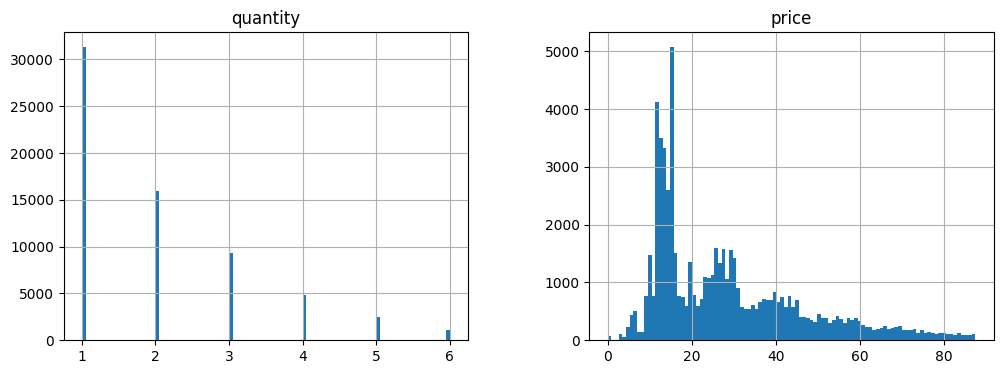

In [13]:
df_no_outliers[qp].hist(bins=100, figsize=(12, 4), layout=(1, 2));

2.3 Results: Removing the outliers didn't significantly change the distrubtion shape of the quantity and price. Since the outliers are not a significant amount (leass than 7% of the dataset) and are plausible dataset values, I am choosing not to remove them. I may reconsider as they could seriously impact future sampling and regression techniques.

In [14]:
# 2.4 Correlation
corr_map = data[qp].corr()
corr_map


,quantity,price
quantity,1.00000,0.90141
price,0.90141,1.00000


In [15]:
# Determine 
customers_frequency = data[['customer_id', 'quantity','price']].groupby(['customer_id']).sum()
customers_frequency

,quantity,price
customer_id,,
1,1,11.77
2,6,89.00
3,16,156.46
4,7,100.50
5,29,385.61
...,...,...
23566,2,36.00
23567,1,20.97
23568,6,121.70


<Axes: xlabel='quantity', ylabel='price'>

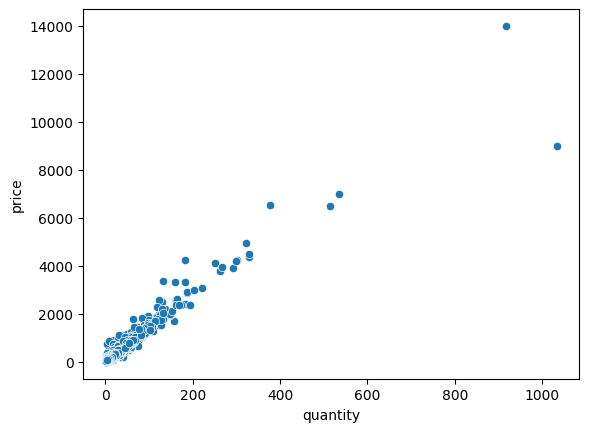

In [16]:
sns.scatterplot(data=customers_frequency,x='quantity',y='price')

<Axes: xlabel='quantity', ylabel='price'>

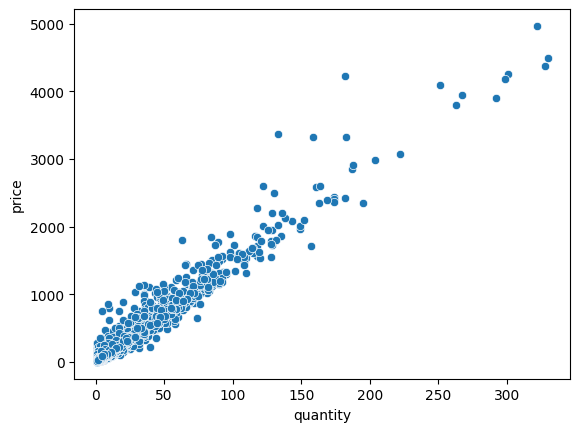

In [17]:
sns.scatterplot(
    data = customers_frequency[ (customers_frequency['quantity']<390 ) & (customers_frequency['price']<5000) ],
    x = 'quantity',
    y='price'
)

<Axes: xlabel='date'>

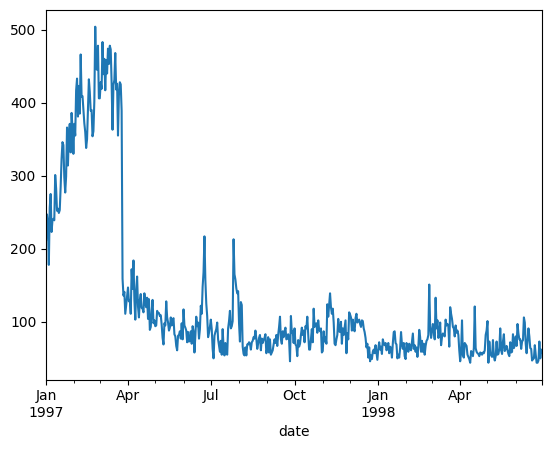

In [18]:
# Daily Transactions
daily_transactions = data.groupby('date').size()
daily_transactions.plot()

2.4 Results: Quantity and Price are highly correlated, which is expected

### 3.0 Prep Dataset for Machine Learning Algorithms

* 3.1 - Separate dataset into Training and Testing sets based on date
* 3.2 - For Training Set, Calculate Recency, Frequency and Monetary values and additional aggregations
* 3.3 - for Testing Set, Calculate actual spend during the past n days

In [19]:
# 3.1a Identify a partition date that is n days before the last dataset record. 
n = 120 # choosing 120 days
data_begin_date, data_final_day = data['date'].min(), data['date'].max() 
partition_date = data_final_day - pd.to_timedelta(n, unit = "d")
print(f"Dataset range is from {data_begin_date.date()} to {data_final_day.date()}. \nPartition date is on {partition_date.date()} which is {n} days before the last date")

Dataset range is from 1997-01-01 to 1998-06-30. 
Partition date is on 1998-03-02 which is 120 days before the last date


In [20]:
# 3.1 b Separate into Training and Testing set based on entries before the n days and within the last n days
training_set = data[data['date']< partition_date]
testing_set =  data[data['date']>= partition_date]
print(f"Training dataset has {training_set.shape[0]} rows which is {100*training_set.shape[0]/data.shape[0]:.2f}% of the dataset entries.")
print(f"Testing dataset has {testing_set.shape[0]} rows which is {100*testing_set.shape[0]/data.shape[0]:.2f}% of the dataset entries.")

Training dataset has 61046 rows which is 87.64% of the dataset entries.
Testing dataset has 8613 rows which is 12.36% of the dataset entries.


In [21]:
# 3.2 Determine RFM Matrix for the training set
# Retrieving the aggregations by customer id 
# Training
rfm_training = training_set.groupby('customer_id') \
    .agg({ \
    "date": [np.count_nonzero, 'min', 'max'],\
    "price": ['mean', 'max', 'sum']\
    } \
) 
rfm_training.columns = ['total_purchases', 'first_order_date', 'last_order_date', 'avg_price', 'max_price','total_price']
rfm_training

,total_purchases,first_order_date,last_order_date,avg_price,max_price,total_price
customer_id,,,,,,
1,1,1997-01-01,1997-01-01,11.770000,11.77,11.77
2,2,1997-01-12,1997-01-12,44.500000,77.00,89.00
3,5,1997-01-02,1997-11-25,27.894000,57.45,139.47
4,4,1997-01-01,1997-12-12,25.125000,29.73,100.50
5,11,1997-01-01,1998-01-03,35.055455,46.46,385.61
...,...,...,...,...,...,...
23566,1,1997-03-25,1997-03-25,36.000000,36.00,36.00
23567,1,1997-03-25,1997-03-25,20.970000,20.97,20.97
23568,3,1997-03-25,1997-04-22,40.566667,83.74,121.70


In [22]:
# Determine the RFM Values for the training set time range
# recency (how recent was the customer's last purchase?) 
# frequency (how often the customer purchased items)  
# monetary (how much did the customer spend)
max_training_date = training_set['date'].max()
rfm_training['recency'] = (rfm_training['first_order_date'] - max_training_date).dt.days
rfm_training['frequency'] = rfm_training['total_purchases'] 
rfm_training['monetary'] = rfm_training['total_price']

# Duration represents the difference in days since the customers first and last purchase
rfm_training['duration'] = ( rfm_training['last_order_date'] - rfm_training['first_order_date']).dt.days


# Keep just the RFM , duration and price aggregations
cols = ['recency','frequency','monetary','duration','avg_price', 'max_price']
rfm_training = rfm_training[cols]


In [23]:
rfm_training

,recency,frequency,monetary,duration,avg_price,max_price
customer_id,,,,,,
1,-424,1,11.77,0,11.770000,11.77
2,-413,2,89.00,0,44.500000,77.00
3,-423,5,139.47,327,27.894000,57.45
4,-424,4,100.50,345,25.125000,29.73
5,-424,11,385.61,367,35.055455,46.46
...,...,...,...,...,...,...
23566,-341,1,36.00,0,36.000000,36.00
23567,-341,1,20.97,0,20.970000,20.97
23568,-341,3,121.70,28,40.566667,83.74


In [24]:
testing_set.columns

Index(['customer_id', 'date', 'quantity', 'price'], dtype='object')

In [25]:
# 3.3 - for Testing Set, Calculate actual spend during the past n days
rfm_testing = testing_set[['customer_id','date','price']].groupby('customer_id')[['price']].sum()
rfm_testing['n_days_spend?']=1
rfm_testing.rename(columns={"price":"spend_total"})

,spend_total,n_days_spend?
customer_id,,
3,16.99,1
7,138.50,1
8,24.46,1
9,41.98,1
25,73.43,1
...,...,...
23534,10.48,1
23537,25.98,1
23555,77.44,1


In [26]:
# 3.4 Combine calculated columns into dataset to be  used for ML
ml_dataset_df = rfm_training.merge(rfm_testing, left_index=True, right_index=True, how = "left").fillna(0)
ml_dataset_df.to_pickle("artifacts/ml_dataset_df.pkl")
ml_dataset_df

,recency,frequency,monetary,duration,avg_price,max_price,price,n_days_spend?
customer_id,,,,,,,,
1,-424,1,11.77,0,11.770000,11.77,0.00,0.0
2,-413,2,89.00,0,44.500000,77.00,0.00,0.0
3,-423,5,139.47,327,27.894000,57.45,16.99,1.0
4,-424,4,100.50,345,25.125000,29.73,0.00,0.0
5,-424,11,385.61,367,35.055455,46.46,0.00,0.0
...,...,...,...,...,...,...,...,...
23566,-341,1,36.00,0,36.000000,36.00,0.00,0.0
23567,-341,1,20.97,0,20.970000,20.97,0.00,0.0
23568,-341,3,121.70,28,40.566667,83.74,0.00,0.0
